# ARIMA #

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, adfuller
from pmdarima import ARIMA

parquet_directory = '/Users/fionachow/Documents/NYU/CDS/Fall 2024/DS - GA 1018 Probabilistic Time Series/Project/electricity_demand_forecasting/data/'
metadata_file = f'{parquet_directory}/metadata.parquet'
demand_file = f'{parquet_directory}/demand.parquet'

metadata = pd.read_parquet(metadata_file)
demand = pd.read_parquet(demand_file)

**Time periods of each time series**

In [2]:
london_data_ids = metadata[metadata['dataset'] == "London Smart Meter Data"]['unique_id'].unique()
london_demand = demand[demand['unique_id'].isin(london_data_ids)]

buildingdg_data_ids = metadata[metadata['dataset'] == "Building Data Genome 2"]['unique_id'].unique()
buildingdg_demand = demand[demand['unique_id'].isin(buildingdg_data_ids)]

eld_data_ids = metadata[metadata['dataset'] == "Electricity Load Diagrams"]['unique_id'].unique()
eld_demand = demand[demand['unique_id'].isin(eld_data_ids)]

datasets = {
    "London Smart Meter Data": london_demand,
    "Building Data Genome 2": buildingdg_demand,
    "Electricity Load Diagrams": eld_demand,
}

results = {}

for name, dataset in datasets.items():
    start_date = dataset['timestamp'].min()
    end_date = dataset['timestamp'].max()
    total_days = (end_date - start_date).days
    total_years = total_days / 365
    results[name] = {
        "start_date": start_date,
        "end_date": end_date,
        "total_years": total_years,
    }

for dataset_name, metrics in results.items():
    print(f"{dataset_name}:")
    print(f"  Start Date: {metrics['start_date']}")
    print(f"  End Date: {metrics['end_date']}")
    print(f"  Total Years: {metrics['total_years']:.2f}\n")


London Smart Meter Data:
  Start Date: 2011-11-23 09:00:00
  End Date: 2014-02-28 00:00:00
  Total Years: 2.27

Building Data Genome 2:
  Start Date: 2016-01-01 00:00:00
  End Date: 2017-12-31 23:00:00
  Total Years: 2.00

Electricity Load Diagrams:
  Start Date: 2011-01-01 00:30:00
  End Date: 2015-01-01 00:00:00
  Total Years: 4.00



In [3]:
print(f"london_demand shape: {london_demand.shape}")

london_demand shape: (168323651, 3)


In [4]:
combined_df = pd.merge(demand, metadata, on='unique_id', how='inner')

/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_1229/335317850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_combined_df['date'] = london_combined_df['timestamp'].dt.date


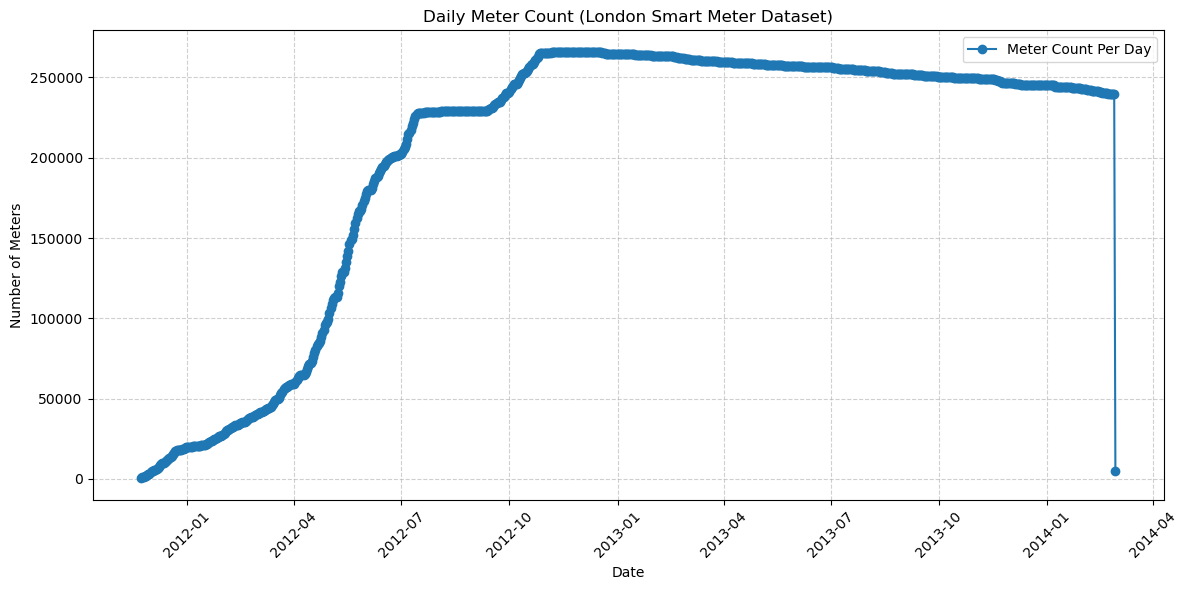

In [7]:
london_combined_df = combined_df[combined_df['dataset'] == 'London Smart Meter Data']

london_combined_df['date'] = london_combined_df['timestamp'].dt.date

daily_meter_count = london_combined_df.groupby('date')['building_id'].count().reset_index()
daily_meter_count.rename(columns={'building_id': 'meter_count'}, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(daily_meter_count['date'], daily_meter_count['meter_count'], marker='o', label='Meter Count Per Day')
plt.title("Daily Meter Count (London Smart Meter Dataset)")
plt.xlabel("Date")
plt.ylabel("Number of Meters")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Choosing to focus on London Smart Meter Data because it is the middle resolution of the three datasets. The data is recorded every 30 minutes.

**Data Preprocessing:** 
- Focusing on valid 30min offsets
- Train/Test Split 80/20
- Aggregating meter data by timestamp

In [17]:
london_demand['timestamp'] = pd.to_datetime(london_demand['timestamp'], errors='coerce')


valid_offsets_set = set(pd.date_range("00:00", "23:59", freq="30T").strftime("%H:%M"))
london_demand['time_offset'] = london_demand['timestamp'].dt.strftime("%H:%M")


london_demand = london_demand[london_demand['time_offset'].isin(valid_offsets_set)]
london_demand = london_demand.drop(columns=['time_offset'])

In [18]:
split_date = london_demand['timestamp'].min() + 0.8 * (london_demand['timestamp'].max() - london_demand['timestamp'].min())

train_data = london_demand[london_demand['timestamp'] < split_date]
test_data = london_demand[london_demand['timestamp'] >= split_date]

In [ ]:
aggregated_train_demand = train_data.groupby('timestamp')['y'].sum().reset_index()
aggregated_test_demand = test_data.groupby('timestamp')['y'].sum().reset_index()

**Plotting the data**

/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_57886/186131851.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])


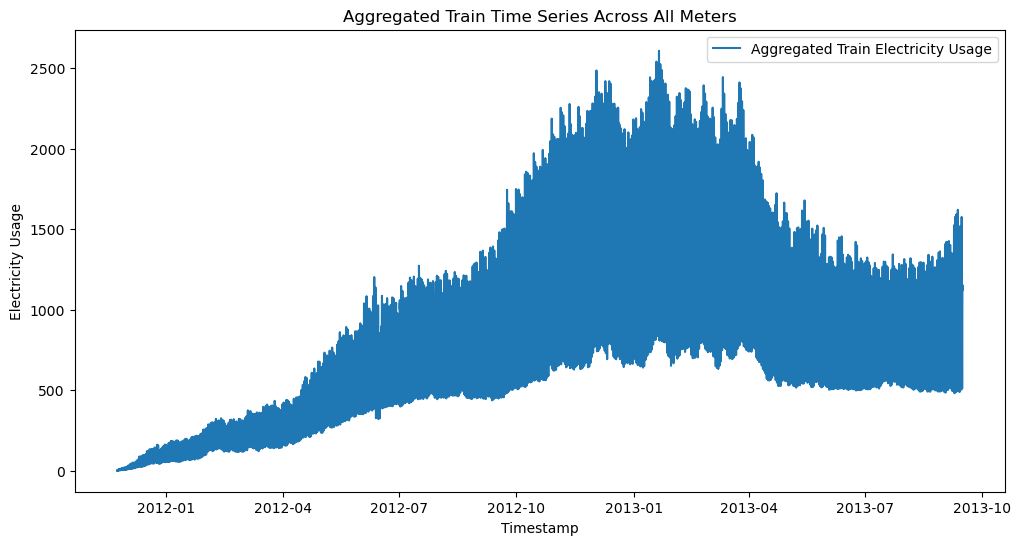

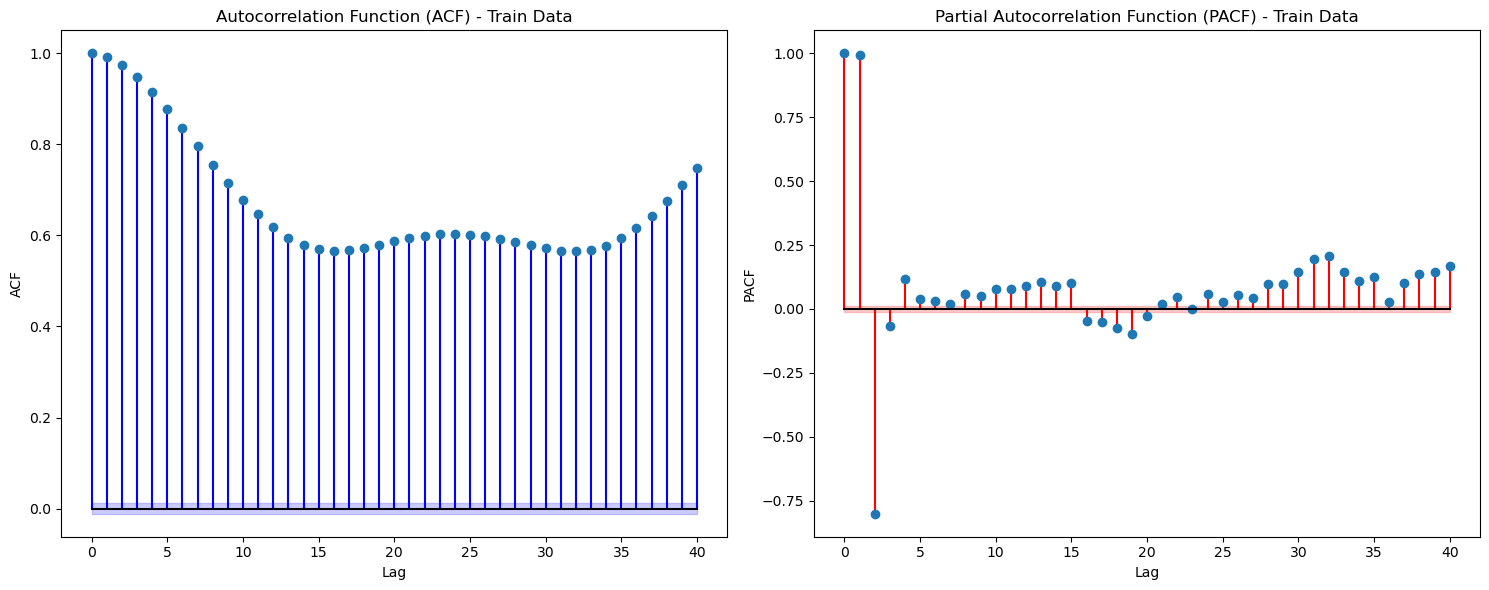

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(aggregated_train_demand['timestamp'], aggregated_train_demand['y'], label='Aggregated Train Electricity Usage')
plt.title("Aggregated Train Time Series Across All Meters")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage")
plt.legend() 
plt.show()

train_signal = aggregated_train_demand['y'].to_numpy()

n_lags = 40  
acf_estimate = acf(train_signal, nlags=n_lags)
pacf_estimate = pacf(train_signal, nlags=n_lags)
acf_error_estimate = 2 / np.sqrt(len(train_signal))  
pacf_error_estimate = 2 / np.sqrt(len(train_signal)) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.stem(range(len(acf_estimate)), acf_estimate, linefmt='b', basefmt='k', use_line_collection=True)
ax1.fill_between(range(len(acf_estimate)), acf_error_estimate, -acf_error_estimate, color='blue', alpha=0.2)
ax1.set_title("Autocorrelation Function (ACF) - Train Data")
ax1.set_xlabel("Lag")
ax1.set_ylabel("ACF")

ax2.stem(range(len(pacf_estimate)), pacf_estimate, linefmt='r', basefmt='k', use_line_collection=True)
ax2.fill_between(range(len(pacf_estimate)), pacf_error_estimate, -pacf_error_estimate, color='red', alpha=0.2)
ax2.set_title("Partial Autocorrelation Function (PACF) - Train Data")
ax2.set_xlabel("Lag")
ax2.set_ylabel("PACF")

plt.tight_layout()
plt.show()

**Differencing the data**

In [ ]:
differenced_train_signal = differenced_series['y'].to_numpy()
adf_test = adfuller(differenced_train_signal)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}") #differenced data once. Went from pvalue = 0.33 to <0.05


ADF Statistic: -44.47854972956265
p-value: 0.0


**Replotted the data after differencing the data once**

In [25]:
differenced_series = aggregated_train_demand.diff().dropna()

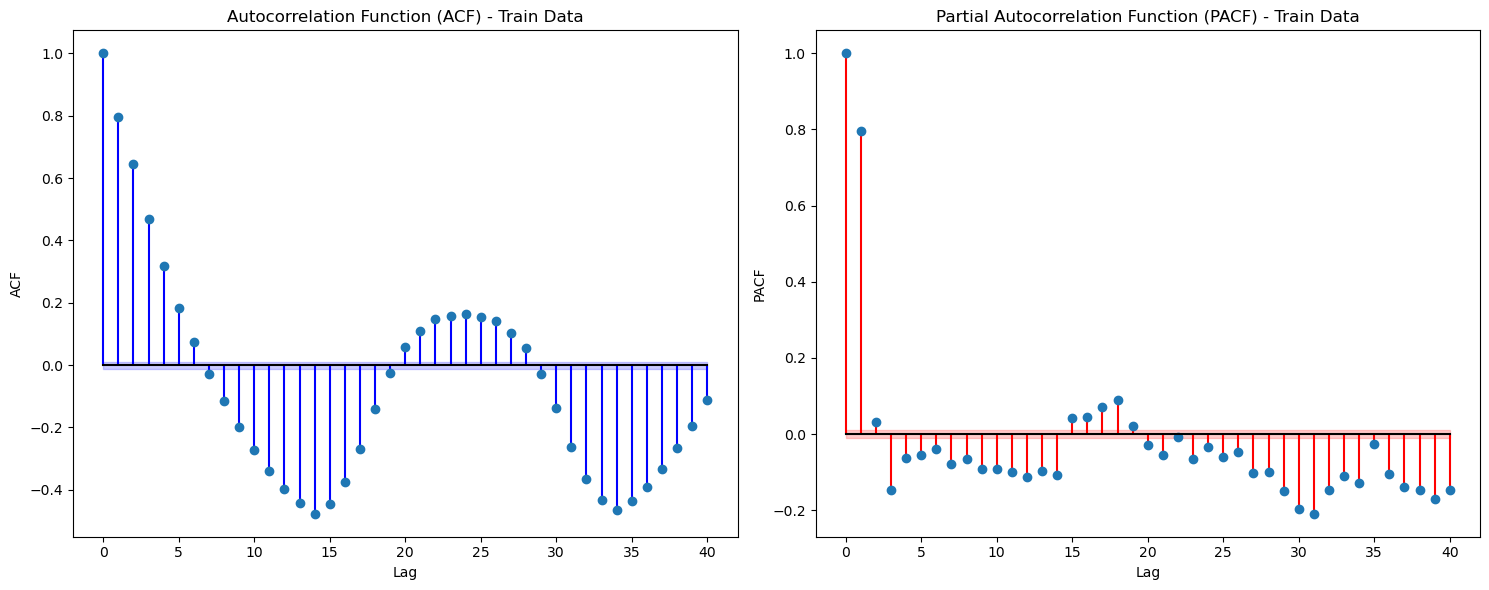

In [55]:
train_signal = differenced_series['y'].to_numpy()

n_lags = 40
acf_estimate = acf(train_signal, nlags=n_lags)
pacf_estimate = pacf(train_signal, nlags=n_lags)
acf_error_estimate = 2 / np.sqrt(len(train_signal))  
pacf_error_estimate = 2 / np.sqrt(len(train_signal)) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.stem(range(len(acf_estimate)), acf_estimate, linefmt='b', basefmt='k', use_line_collection=True)
ax1.fill_between(range(len(acf_estimate)), acf_error_estimate, -acf_error_estimate, color='blue', alpha=0.2)
ax1.set_title("Autocorrelation Function (ACF) - Train Data")
ax1.set_xlabel("Lag")
ax1.set_ylabel("ACF")

ax2.stem(range(len(pacf_estimate)), pacf_estimate, linefmt='r', basefmt='k', use_line_collection=True)
ax2.fill_between(range(len(pacf_estimate)), pacf_error_estimate, -pacf_error_estimate, color='red', alpha=0.2)
ax2.set_title("Partial Autocorrelation Function (PACF) - Train Data")
ax2.set_xlabel("Lag")
ax2.set_ylabel("PACF")

plt.tight_layout()
plt.show()

**Modeling**
- Trying baseline model ARIMA (1,1,0) based on the above ACF/PACF plots

Fitting the ARIMA(1, 1, 0) model on the entire training dataset...
Forecasting...
Evaluation Metrics:
  MAPE: 0.4494
  RMSE: 454.0787


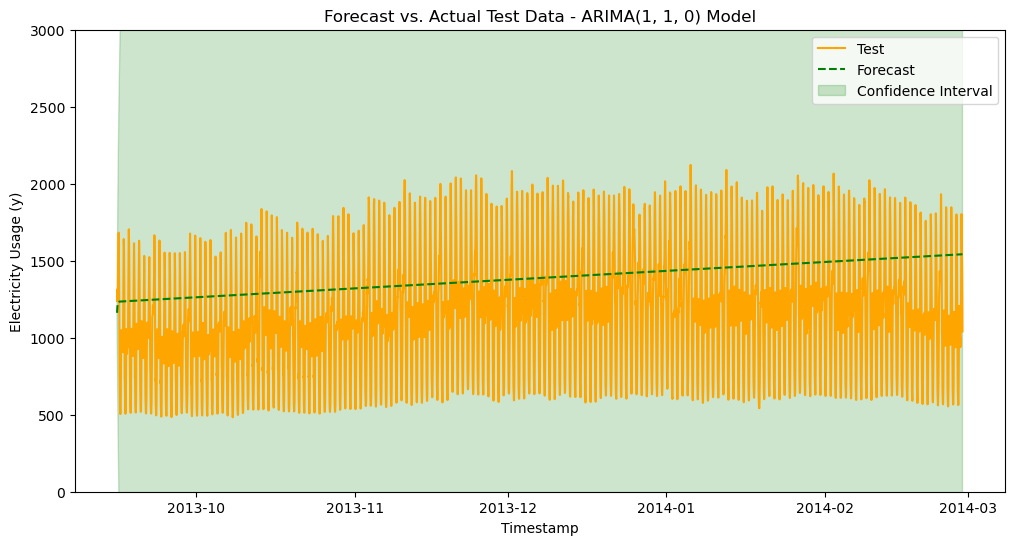

In [43]:
train_series = aggregated_train_demand.set_index('timestamp')['y']
test_series = aggregated_test_demand.set_index('timestamp')['y']

print("Fitting the ARIMA(1, 1, 0) model on the entire training dataset...")
model = ARIMA(order=(1, 1, 0), suppress_warnings=True)
model.fit(train_series)

print("Forecasting...")
forecast_values, conf_int = model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - ARIMA(1, 1, 0) Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.ylim(0, 3000) 
plt.legend()
plt.show()

Also tried to use the auto_arima function from the pmdarima library to find the best ARIMA model for the data.

Fitting ARMA model using auto_arima...
Performing stepwise search to minimize aic


/Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=352222.741, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=320252.333, Time=1.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=334559.709, Time=3.90 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=352220.752, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=320225.265, Time=1.69 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=319524.342, Time=1.76 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=319401.922, Time=2.29 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=319308.556, Time=2.95 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=319261.724, Time=3.89 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=319066.469, Time=4.74 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=318927.538, Time=6.56 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=318655.227, Time=7.90 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=318389.678, Time=8.39 sec
 ARIMA(11,1,0)(0,0,0)[0] intercept   : AIC=318069.918, Time=9.10 sec
 ARIMA(12,1,0)(0,0,0)[0] intercept   : AIC=317

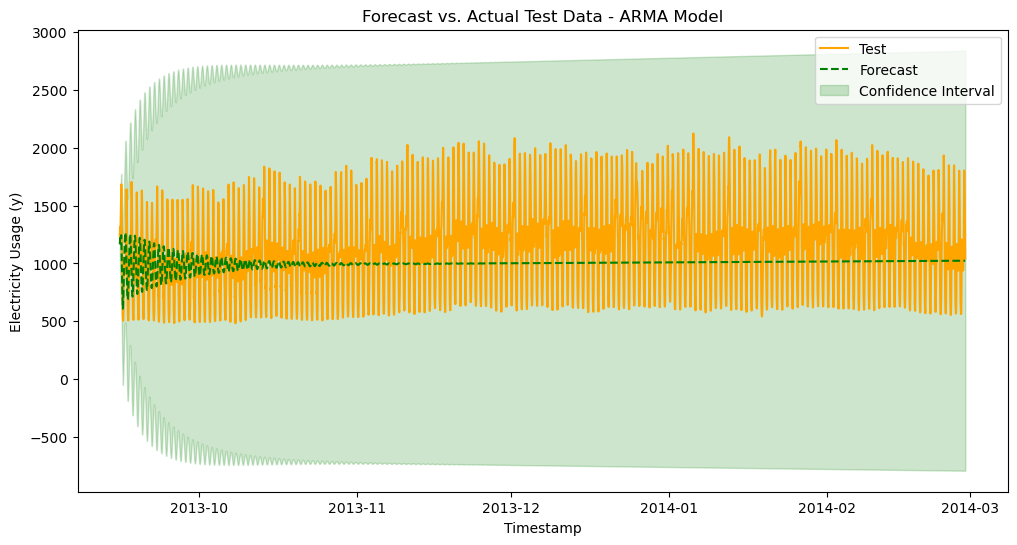

In [52]:
from pmdarima import auto_arima

print("Fitting ARMA model using auto_arima...")
arma_model = auto_arima(
    train_series,
    start_p=0, max_p=20,  
    start_q=0, max_q=20,  
    seasonal=False,      
    stepwise=True,       
    d = 1,
    trace=True,          
    suppress_warnings=True, 
    information_criterion='aic',  
    n_jobs=-1          
)

print(f"Best ARMA model order: {arma_model.order}")

print("Forecasting...")
forecast_values, conf_int = arma_model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - ARMA Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.legend()
plt.show()

**Exploring a 1-Day Interval for the ARIMA Model (average meter consumption)**

/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_1229/986455596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_demand['date'] = london_demand['timestamp'].dt.date  # Extract the date from the timestamp


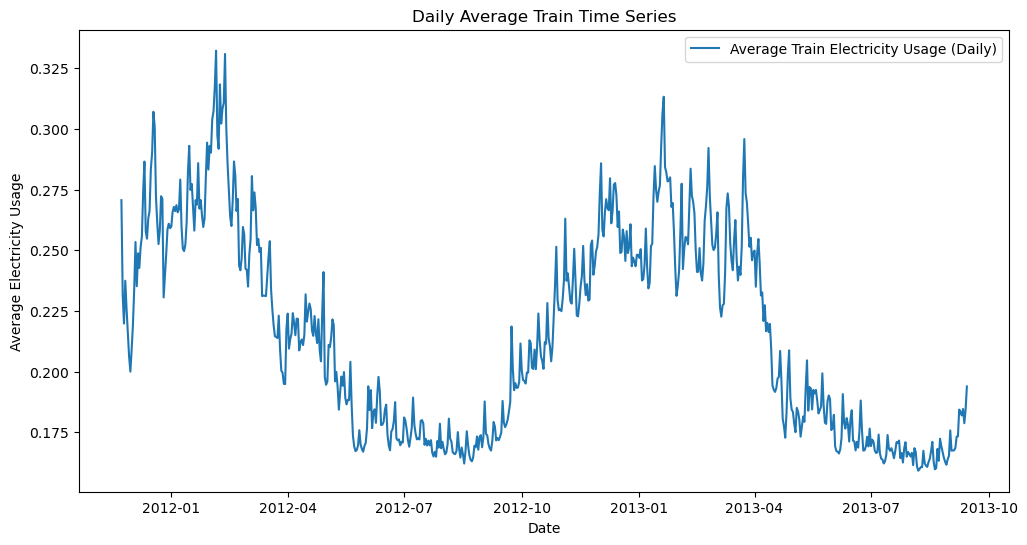

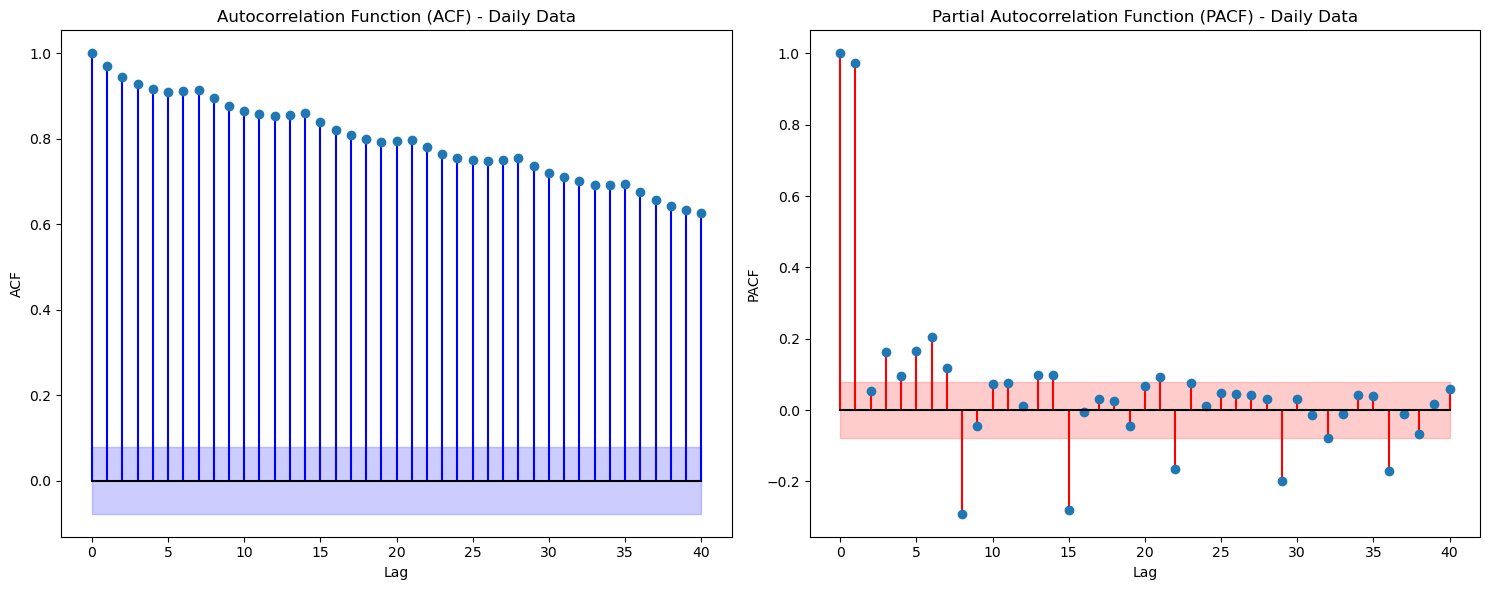

In [8]:
london_demand['date'] = london_demand['timestamp'].dt.date  

daily_demand = london_demand.groupby('date')['y'].mean().reset_index() 

split_date_daily = daily_demand['date'].min() + 0.8 * (daily_demand['date'].max() - daily_demand['date'].min())
split_date_daily = pd.to_datetime(split_date_daily).date()  

train_data_daily = daily_demand[daily_demand['date'] < split_date_daily]
test_data_daily = daily_demand[daily_demand['date'] >= split_date_daily]

plt.figure(figsize=(12, 6))
plt.plot(train_data_daily['date'], train_data_daily['y'], label='Average Train Electricity Usage (Daily)')
plt.title("Daily Average Train Time Series")
plt.xlabel("Date")
plt.ylabel("Average Electricity Usage")
plt.legend()
plt.show()

train_signal_daily = train_data_daily['y'].to_numpy()

n_lags_daily = 40  
acf_estimate_daily = acf(train_signal_daily, nlags=n_lags_daily)
pacf_estimate_daily = pacf(train_signal_daily, nlags=n_lags_daily)
acf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))
pacf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.stem(range(len(acf_estimate_daily)), acf_estimate_daily, linefmt='b', basefmt='k', use_line_collection=True)
ax1.fill_between(range(len(acf_estimate_daily)), acf_error_estimate_daily, -acf_error_estimate_daily, color='blue', alpha=0.2)
ax1.set_title("Autocorrelation Function (ACF) - Daily Data")
ax1.set_xlabel("Lag")
ax1.set_ylabel("ACF")

ax2.stem(range(len(pacf_estimate_daily)), pacf_estimate_daily, linefmt='r', basefmt='k', use_line_collection=True)
ax2.fill_between(range(len(pacf_estimate_daily)), pacf_error_estimate_daily, -pacf_error_estimate_daily, color='red', alpha=0.2)
ax2.set_title("Partial Autocorrelation Function (PACF) - Daily Data")
ax2.set_xlabel("Lag")
ax2.set_ylabel("PACF")

plt.tight_layout()
plt.show()


In [ ]:
adf_test = adfuller(train_signal_daily)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")  

ADF Statistic: -1.744059715001038
p-value: 0.40856637316149313


In [11]:
differenced_series = daily_demand.diff().dropna() #differenced data once

differenced_train_signal = differenced_series['y'].to_numpy()
adf_test = adfuller(differenced_train_signal)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}") 

ADF Statistic: -6.6753397613307275
p-value: 4.479972536543365e-09


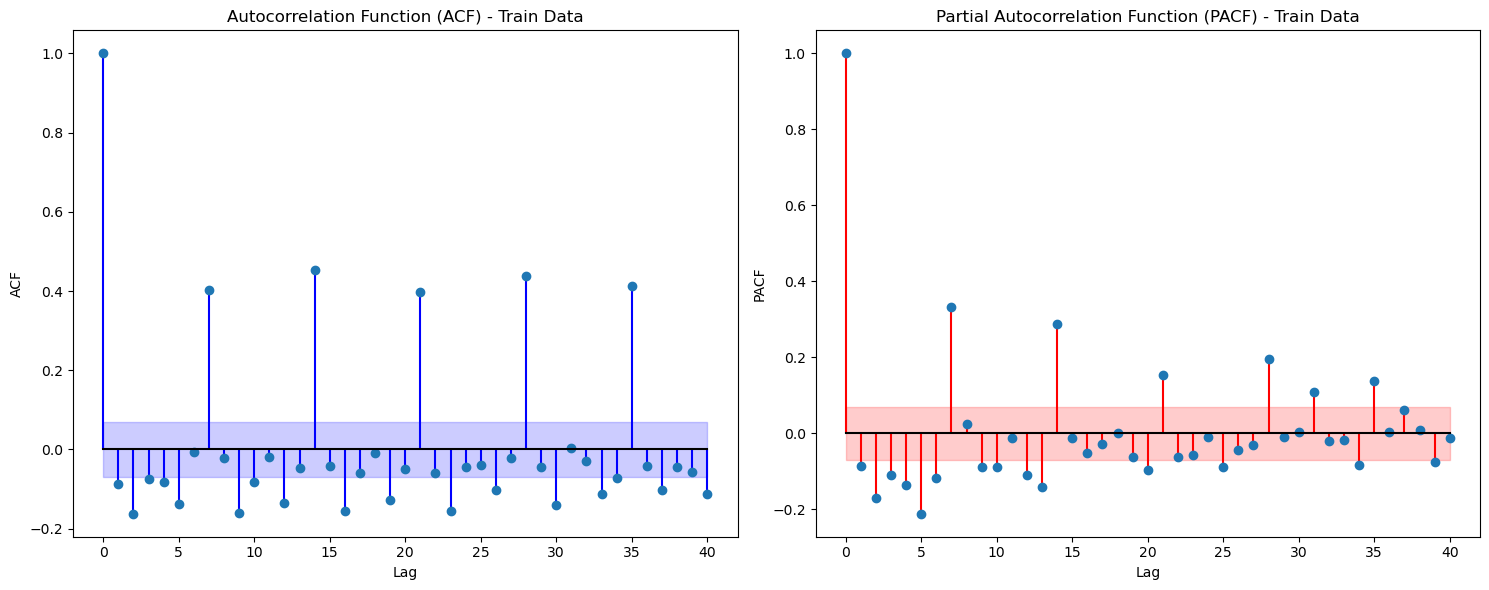

In [12]:
train_signal = differenced_series['y'].to_numpy()

n_lags = 40
acf_estimate = acf(train_signal, nlags=n_lags)
pacf_estimate = pacf(train_signal, nlags=n_lags)
acf_error_estimate = 2 / np.sqrt(len(train_signal))  
pacf_error_estimate = 2 / np.sqrt(len(train_signal)) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.stem(range(len(acf_estimate)), acf_estimate, linefmt='b', basefmt='k', use_line_collection=True)
ax1.fill_between(range(len(acf_estimate)), acf_error_estimate, -acf_error_estimate, color='blue', alpha=0.2)
ax1.set_title("Autocorrelation Function (ACF) - Train Data")
ax1.set_xlabel("Lag")
ax1.set_ylabel("ACF")

ax2.stem(range(len(pacf_estimate)), pacf_estimate, linefmt='r', basefmt='k', use_line_collection=True)
ax2.fill_between(range(len(pacf_estimate)), pacf_error_estimate, -pacf_error_estimate, color='red', alpha=0.2)
ax2.set_title("Partial Autocorrelation Function (PACF) - Train Data")
ax2.set_xlabel("Lag")
ax2.set_ylabel("PACF")

plt.tight_layout()
plt.show()

Fitting the ARIMA(0, 1, 0) model on the entire training dataset...
Forecasting...
Evaluation Metrics:
  MAPE: 0.1825
  RMSE: 0.0492


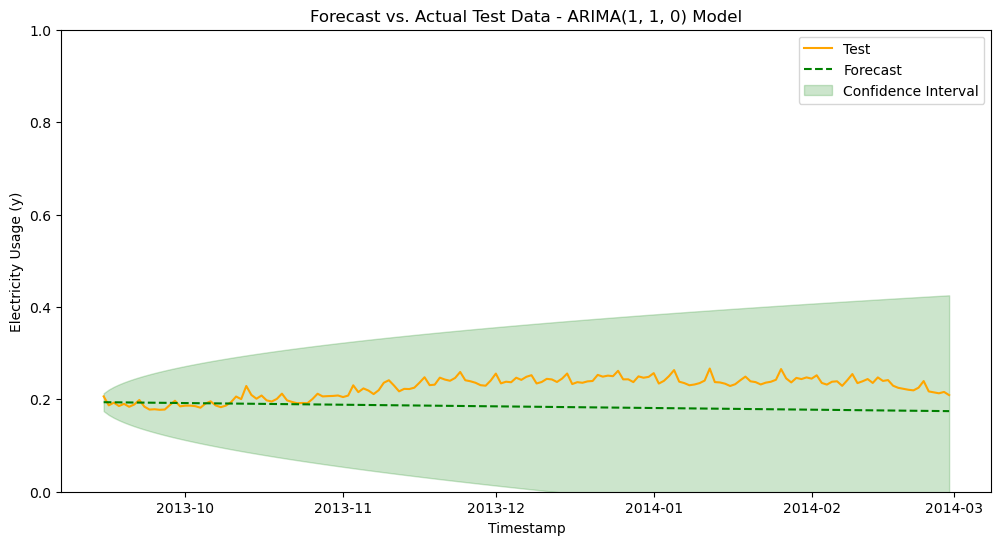

In [21]:
train_series = train_data_daily.set_index('date')['y']
test_series = test_data_daily.set_index('date')['y']

print("Fitting the ARIMA(0, 1, 0) model on the entire training dataset...")
model = ARIMA(order=(0, 1, 0), suppress_warnings=True)
model.fit(train_series)

print("Forecasting...")
forecast_values, conf_int = model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - ARIMA(1, 1, 0) Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.ylim(0, 1) 
plt.legend()
plt.show()

**SARIMA**

In [ ]:
print("Fitting the SARIMA(1, 1, 0)(1, 1, 0, 48) model on the entire training dataset...")
model = ARIMA(order=(1, 1, 0), seasonal_order=(1, 1, 0, 48), suppress_warnings=True)
model.fit(train_series)

print("Forecasting...")
forecast_values, conf_int = model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - SARIMA(1, 1, 0)(1, 1, 0, 48) Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.ylim(0, 3000)  
plt.legend()
plt.show()
